<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_weights_Code_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
# shape of the data matrix
data.shape

(20000, 785)

In [4]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


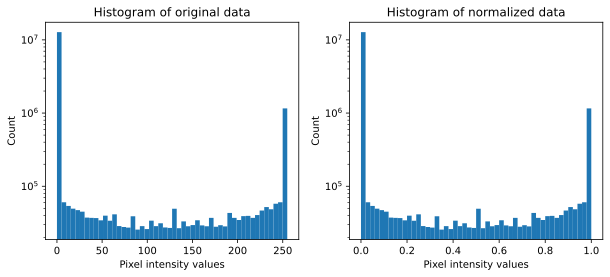

In [5]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

## Create train/test groups using dataloader

In [6]:
# step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Create the DL model

In [7]:
# create a class for the model

def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

## Explore the weights

In [8]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[ 0.0538, -0.0792, -0.0179,  ..., -0.0525,  0.0106,  0.0338],
        [ 0.0674, -0.0793, -0.0577,  ..., -0.0069, -0.0779, -0.0098],
        [-0.0053,  0.0041,  0.0441,  ..., -0.0610,  0.0662, -0.1209],
        ...,
        [ 0.0668,  0.0734, -0.0389,  ...,  0.0444,  0.0138, -0.0513],
        [-0.0879,  0.0508, -0.0383,  ...,  0.0528,  0.0372, -0.0111],
        [-0.0543, -0.0320,  0.0931,  ..., -0.0882, -0.0103,  0.0624]])


In [9]:
def function2trainTheModel(net, lossfun, optimizer):

    # number of epochs
    numepochs = 10

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

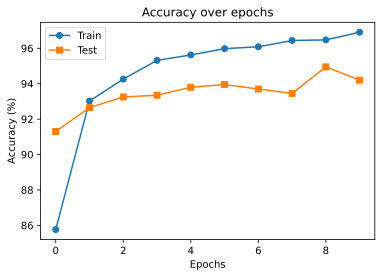

In [10]:
net_base, lossfun, optimizer = createTheMNISTNet()
trainAcc_base, testAcc_base, losses, net_base = function2trainTheModel(net_base, lossfun, optimizer)

#plot the results
plt.plot(range(len(trainAcc_base)), trainAcc_base, 'o-', range(len(testAcc_base)), testAcc_base, 's-')
plt.legend(['Train', 'Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [26]:
# Change the weights before training
stds = np.logspace(np.log10(.0001), np.log10(10), 25)
testResults = np.zeros((len(stds)))
models = []
for si, std in enumerate(stds):

    print(f'{si+1}/{len(stds)}: weight initialized with normal distribution having {std} std')
        
    net, lossfun, optimizer = createTheMNISTNet()

    # loop over parameters and set them all to zeros
    for p in net.named_parameters():
        p[1].data = torch.normal(mean=0, std=std, size=p[1].data.shape)

    trainAcc, testAcc, losses, net = function2trainTheModel(net, lossfun, optimizer)
    testResults[si] = np.mean(testAcc[-3:])
    models.append(net)


# # and confirm for a few select parameters (y-axis offset for visibility)
# plt.plot(0+net_allzero.fc1.weight.data.flatten(), 'bo')
# plt.plot(1+net_allzero.fc2.weight.data.flatten(), 'rx')
# plt.plot(2+net_allzero.fc1.bias.data.flatten(), 'g^')
# plt.xlabel("Parameter index")
# plt.ylim([-1, 3])
# plt.ylabel('Parameter value')
# plt.show()

1/25: weight initialized with normal distribution having 0.0001 std
2/25: weight initialized with normal distribution having 0.00016155980984398745 std
3/25: weight initialized with normal distribution having 0.0002610157215682536 std
4/25: weight initialized with normal distribution having 0.00042169650342858224 std
5/25: weight initialized with normal distribution having 0.0006812920690579615 std
6/25: weight initialized with normal distribution having 0.0011006941712522103 std
7/25: weight initialized with normal distribution having 0.0017782794100389228 std
8/25: weight initialized with normal distribution having 0.0028729848333536655 std
9/25: weight initialized with normal distribution having 0.004641588833612782 std
10/25: weight initialized with normal distribution having 0.007498942093324558 std
11/25: weight initialized with normal distribution having 0.012115276586285889 std
12/25: weight initialized with normal distribution having 0.019573417814876617 std
13/25: weight init

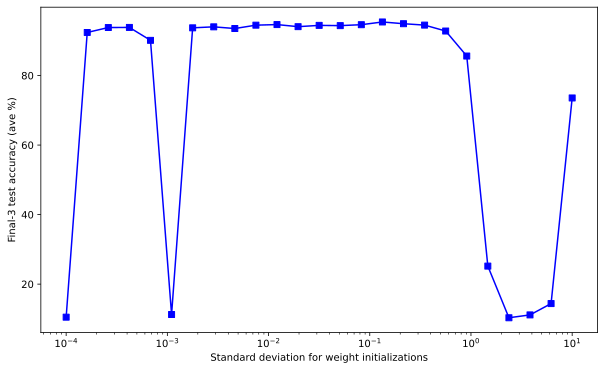

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(stds, testResults, 'bs-')
plt.xlabel('Standard deviation for weight initializations')
plt.xscale('log')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.show()

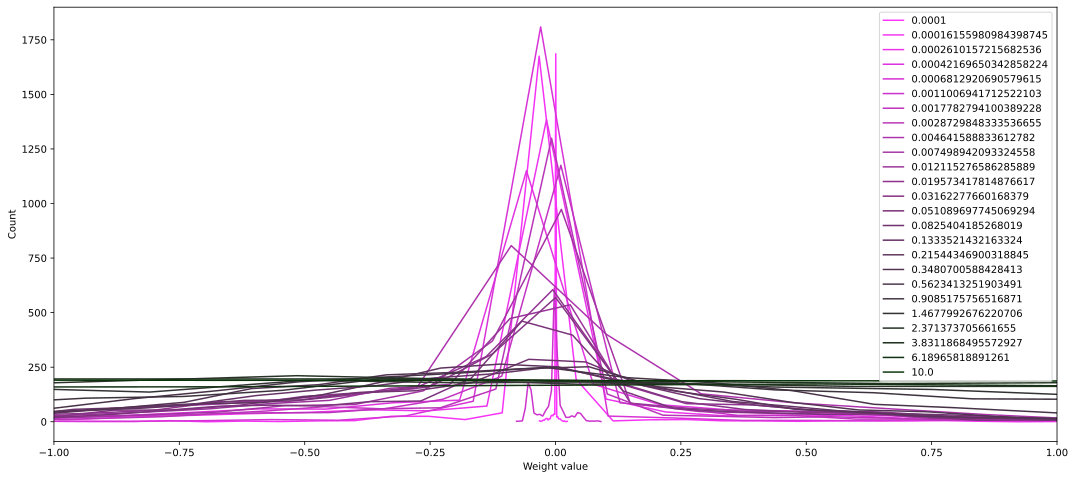

In [31]:
plt.figure(figsize=(18, 8))
# show the distributions in a histogram
for i, net in enumerate(models):
    y, x = np.histogram(net.fc1.weight.data.flatten(), 30)
    plt.plot((x[1:] + x[:-1])/ 2, y, label=f'{stds[i]}', color=[1-i/len(models), .2, 1-i/len(models)])


plt.legend()
plt.xlabel('Weight value') 
plt.xlim([-1, 1])
plt.ylabel('Count')
plt.show()